In [1]:
import pandas as pd
import numpy as np
import math
import itertools
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis, TruncatedSVD
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import mixture
from umap.umap_ import UMAP

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as offline

import warnings
warnings.filterwarnings('ignore')

2022-04-12 21:13:28.895969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 21:13:28.896070: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# read all the datasets
datasets = {}

for i in range(1,6):
  filename = "Assignment2_Datasets/dataset" + str(i) + ".csv"
  # read file
  data = pd.read_csv(filename)

  # rename the fisrt column
  data.rename(index=str, columns={'Unnamed: 0':"Cells"},inplace=True)

  # make cells as the index
  data = data.set_index('Cells')

  # transpose the dataframe so as the Cells to become the features
  data = data.T

  datasets[i] = data

32
22
34
17
27


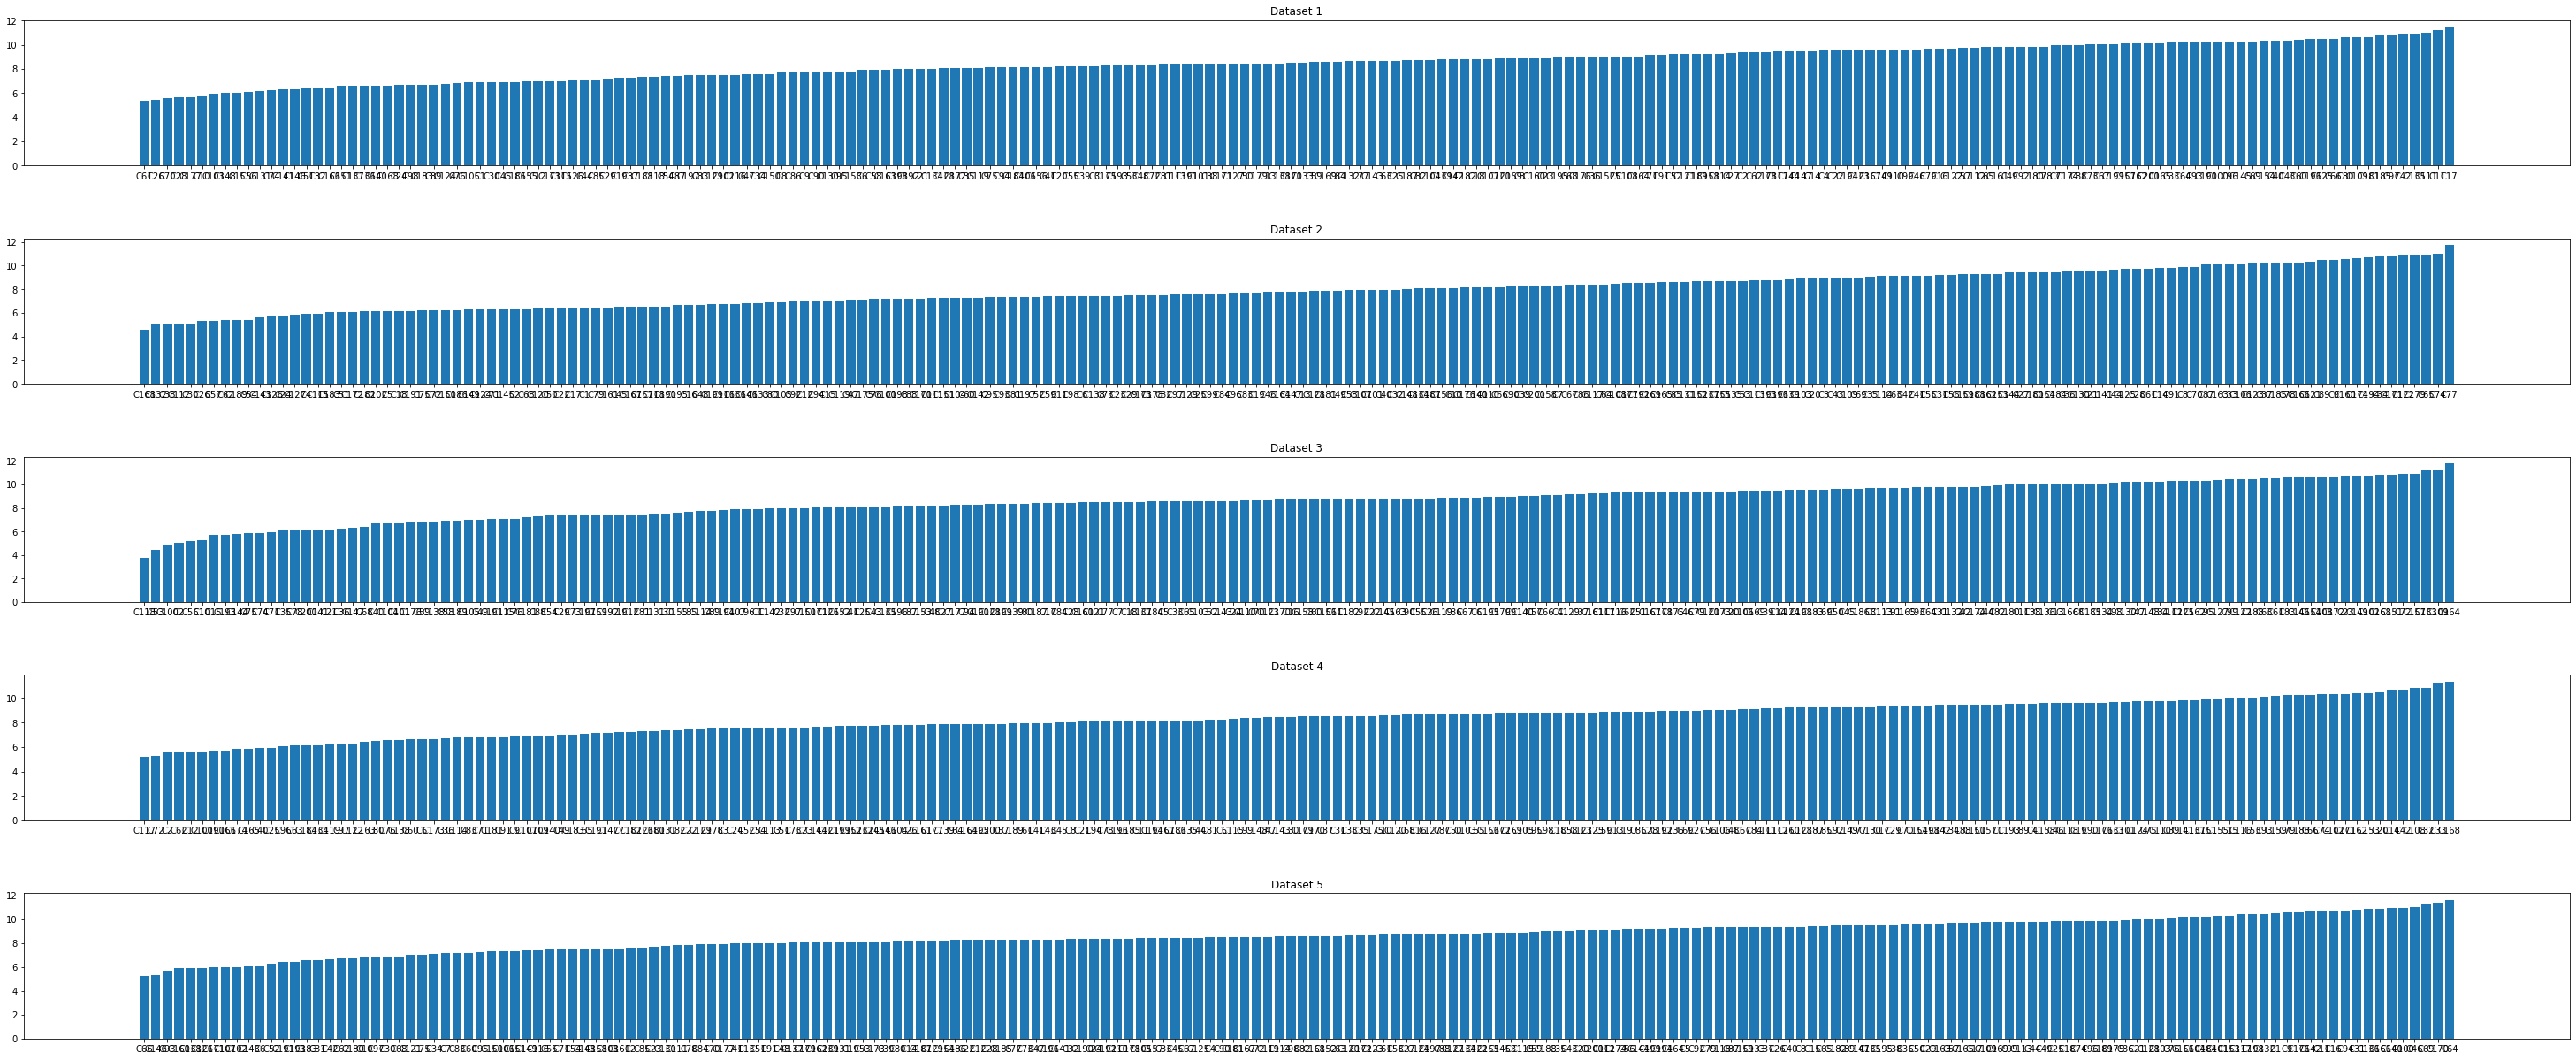

In [28]:
fig, axes = plt.subplots(5, 1, figsize=(50, 20))

# Low Variance Check
for i in range(1,6):
  a = datasets[i].var()
  b = datasets[i].corr(method='pearson')
  k = 0
  a = a.sort_values()
  axes[i-1].bar(a.index, a.values)
  axes[i-1].set_title("Dataset " + str(i))
  for i in range(0,200):
    if a[i] > 10: # check the variables having low variance as compared to other variables in our dataset, because variables with a low variance will not affect the target variable.
      k+=1
  print(k)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.5)
plt.show()

In [8]:
datasets_st = {}
#Standardize features by removing the mean and scaling to unit variance.
for i in range(1,6):
  df_st =  StandardScaler().fit_transform(datasets[i])  
  # pd.DataFrame(df_st, columns=datasets[i].columns).head(2)
  datasets_st[i] = df_st

## Dimensionality reduction

### Factor Analysis

In [17]:
# Create factor analysis object and perform factor analysis
n_factors_fa = {}
for i in range(1,6):
  fa = FactorAnalyzer()
  fa.fit(datasets[i])

  # Check Eigenvalues
  ev, v = fa.get_eigenvalues()
  n_factors = 0

  for j in ev:
    if j > 1: # Number eigenvalues greater than one considered as the number of factors.
      n_factors +=1
      
  # save the number of factors for each component    
  n_factors_fa[i] = n_factors
  print('Number of factors for dataset ' + str(i) + ' is ' + str(n_factors))

Number of factors for dataset 1 is 50
Number of factors for dataset 2 is 51
Number of factors for dataset 3 is 49
Number of factors for dataset 4 is 52
Number of factors for dataset 5 is 50


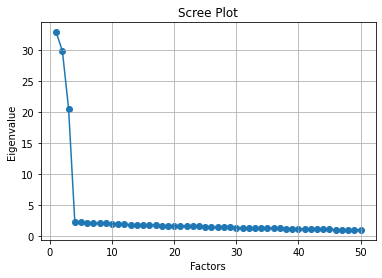

In [11]:
# Create scree plot to determine the number of factors for the last dataset
plt.scatter(range(1,51),ev[:50])
plt.plot(range(1,51),ev[:50])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

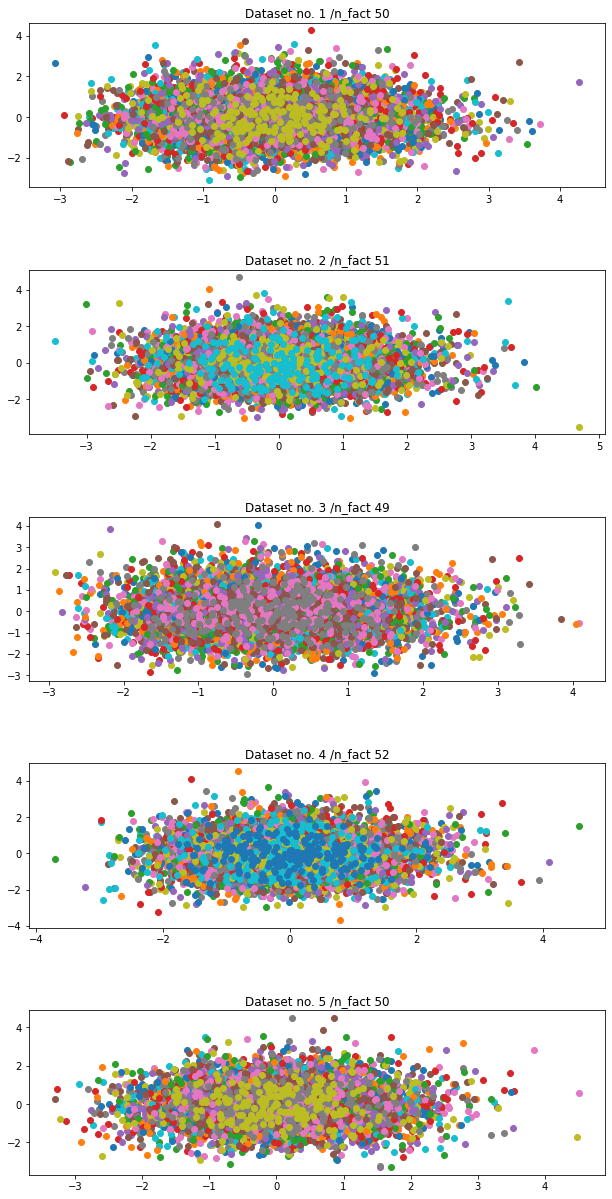

In [67]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
# Create factor analysis object and perform factor analysis for each dataset
for i in range(1,6):
  fa_components = FactorAnalysis(n_components=n_factors_fa[i]).fit_transform(datasets[i])
  for index in range(0, fa_components.shape[1]-1):
    if index == 49:
      axes[i-1].scatter(fa_components[:,index], fa_components[:,0])
    else:
      axes[i-1].scatter(fa_components[:,index], fa_components[:,index+1])
  
  axes[i-1].set_title("Dataset no. " + str(i) + " /n_fact " + str(fa_components.shape[1]))
  
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.5)
plt.show()

### PCA


In [25]:
principalComponents = {}
var_exp = {}

for i in range(1,6):
  # run PCA so as to give us the number of components that achives 80% of information
  pca = PCA(n_components=0.8)
  principalComponents[i] = pca.fit(datasets[i])

  # this shows us the contribution of each component
  var_exp[i] = principalComponents[i].explained_variance_ratio_
  # cum_var_exp = np.cumsum(var_exp)

  print("Number of PCA for dataset " + str(i) + " is " + str(principalComponents[i].components_.shape[0]))

Number of PCA for dataset 1 is 56
Number of PCA for dataset 2 is 56
Number of PCA for dataset 3 is 55
Number of PCA for dataset 4 is 57
Number of PCA for dataset 5 is 56


In [26]:
# plot the components in accordance with the explained variance of each one for dataset1
x = ["PC%s" %i for i in range(1,principalComponents[1].components_.shape[0] + 1)]
trace1 = go.Bar(
    x=x,
    y=list(var_exp[1]),
    name="Explained Variance")

trace2 = go.Scatter(
    x=x,
    y=np.cumsum(var_exp[1]),
    name="Cumulative Variance")

layout = go.Layout(
    title='Explained variance',
    xaxis=dict(title='Principle Components', tickmode='linear'))

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

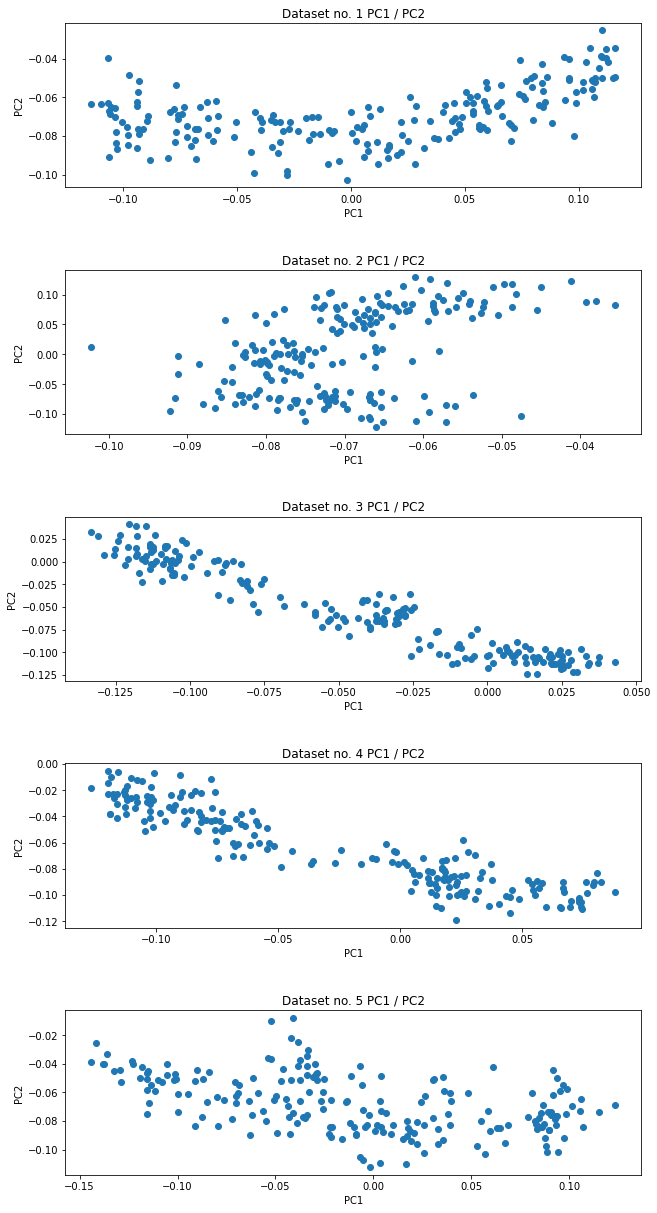

In [37]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
# Create factor analysis object and perform factor analysis for each dataset
for i in range(1,6):
  # make dataframe for the components
  loadings = principalComponents[i].components_
  num_pc = principalComponents[i].n_features_
  pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
  loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
  loadings_df['variable'] = datasets[i].columns.values
  loadings_df = loadings_df.set_index('variable')

  axes[i-1].scatter(loadings_df['PC1'], loadings_df['PC2'])
  axes[i-1].set_xlabel("PC1")
  axes[i-1].set_ylabel("PC2")
  axes[i-1].set_title("Dataset no. " + str(i) + " PC1 / PC2")
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.5)
plt.show()

In [68]:
# The sum of variance of the 2 principal components for each dataset
for i in range(1,6):
  print("Total variance of PC1 and PC2 for dataset " + str(i) + " is " + str(round(sum(principalComponents[i].explained_variance_ratio_[0:2]), 2)))

Total variance of PC1 and PC2 for dataset 1 is 0.41
Total variance of PC1 and PC2 for dataset 2 is 0.36
Total variance of PC1 and PC2 for dataset 3 is 0.37
Total variance of PC1 and PC2 for dataset 4 is 0.36
Total variance of PC1 and PC2 for dataset 5 is 0.32


### SVD

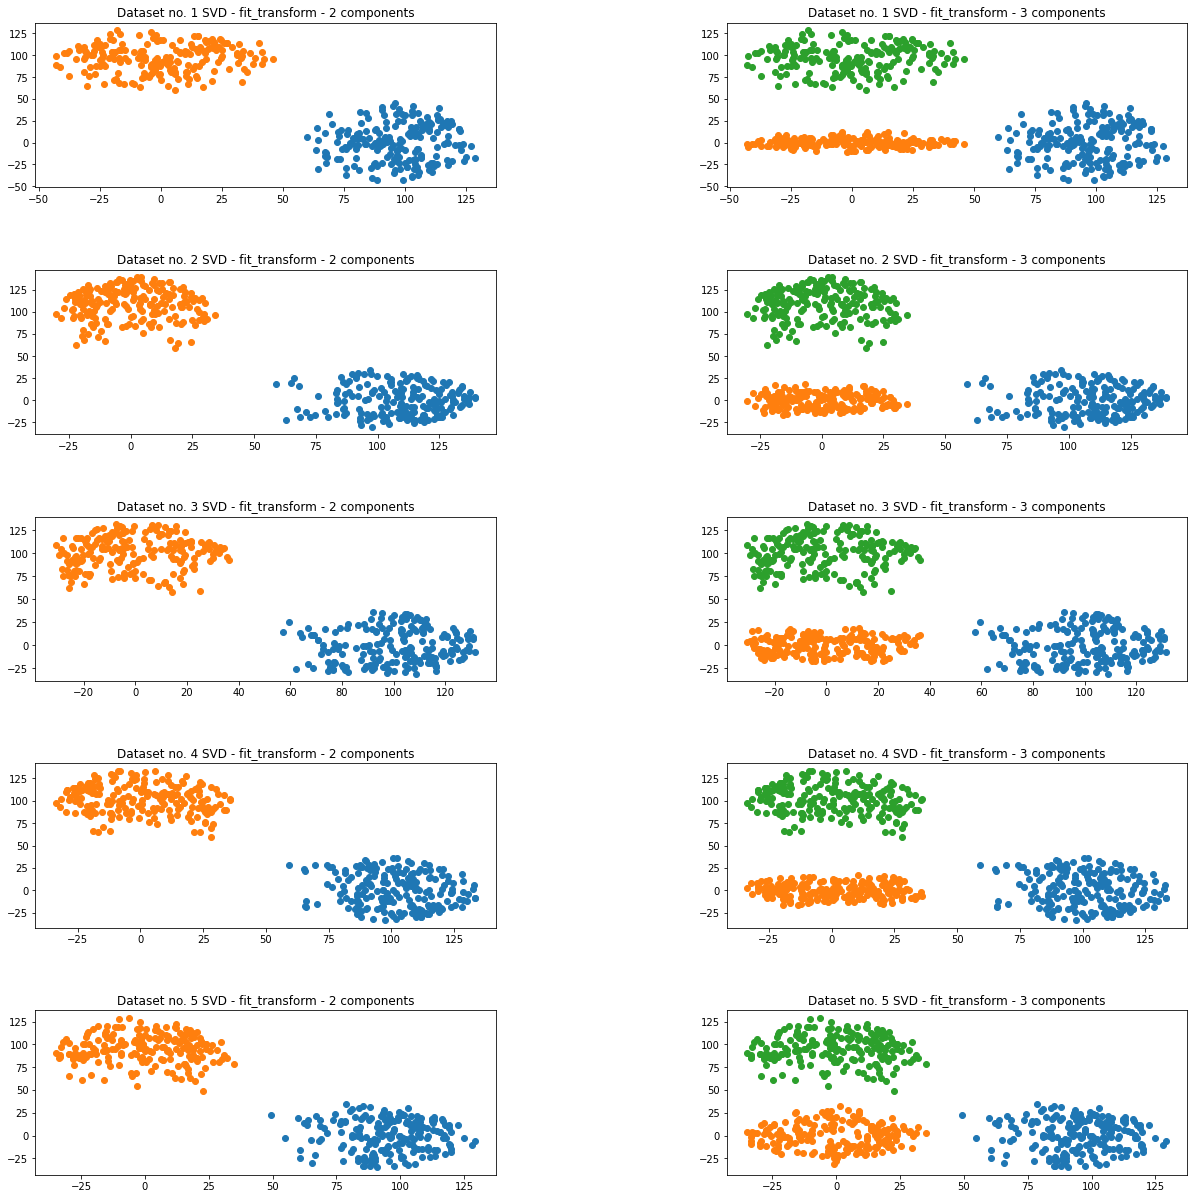

In [48]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
for i in range(1,6):
  # calculate SVD with fit_transform for each dataset for 2 and 3 components
  svd2 = TruncatedSVD(n_components=2, random_state=42).fit_transform(datasets[i])
  svd3 = TruncatedSVD(n_components=3, random_state=42).fit_transform(datasets[i])

  axes[i-1, 0].scatter(svd2[:,0], svd2[:,1])
  axes[i-1, 0].scatter(svd2[:,1],svd2[:,0])
  axes[i-1, 0].set_title("Dataset no. " + str(i) + " SVD - fit_transform - 2 components")
  
  axes[i-1, 1].scatter(svd3[:,0], svd3[:,1])
  axes[i-1, 1].scatter(svd3[:,1], svd3[:,2])
  axes[i-1, 1].scatter(svd3[:,1],svd3[:,0])
  axes[i-1, 1].set_title("Dataset no. " + str(i) + " SVD - fit_transform - 3 components")


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

Total variance for dataset 1 with n_comp = 2 is 0.4 and with n_comp = 3 is 0.42
Total variance for dataset 2 with n_comp = 2 is 0.36 and with n_comp = 3 is 0.4
Total variance for dataset 3 with n_comp = 2 is 0.37 and with n_comp = 3 is 0.42
Total variance for dataset 4 with n_comp = 2 is 0.36 and with n_comp = 3 is 0.4
Total variance for dataset 5 with n_comp = 2 is 0.32 and with n_comp = 3 is 0.42


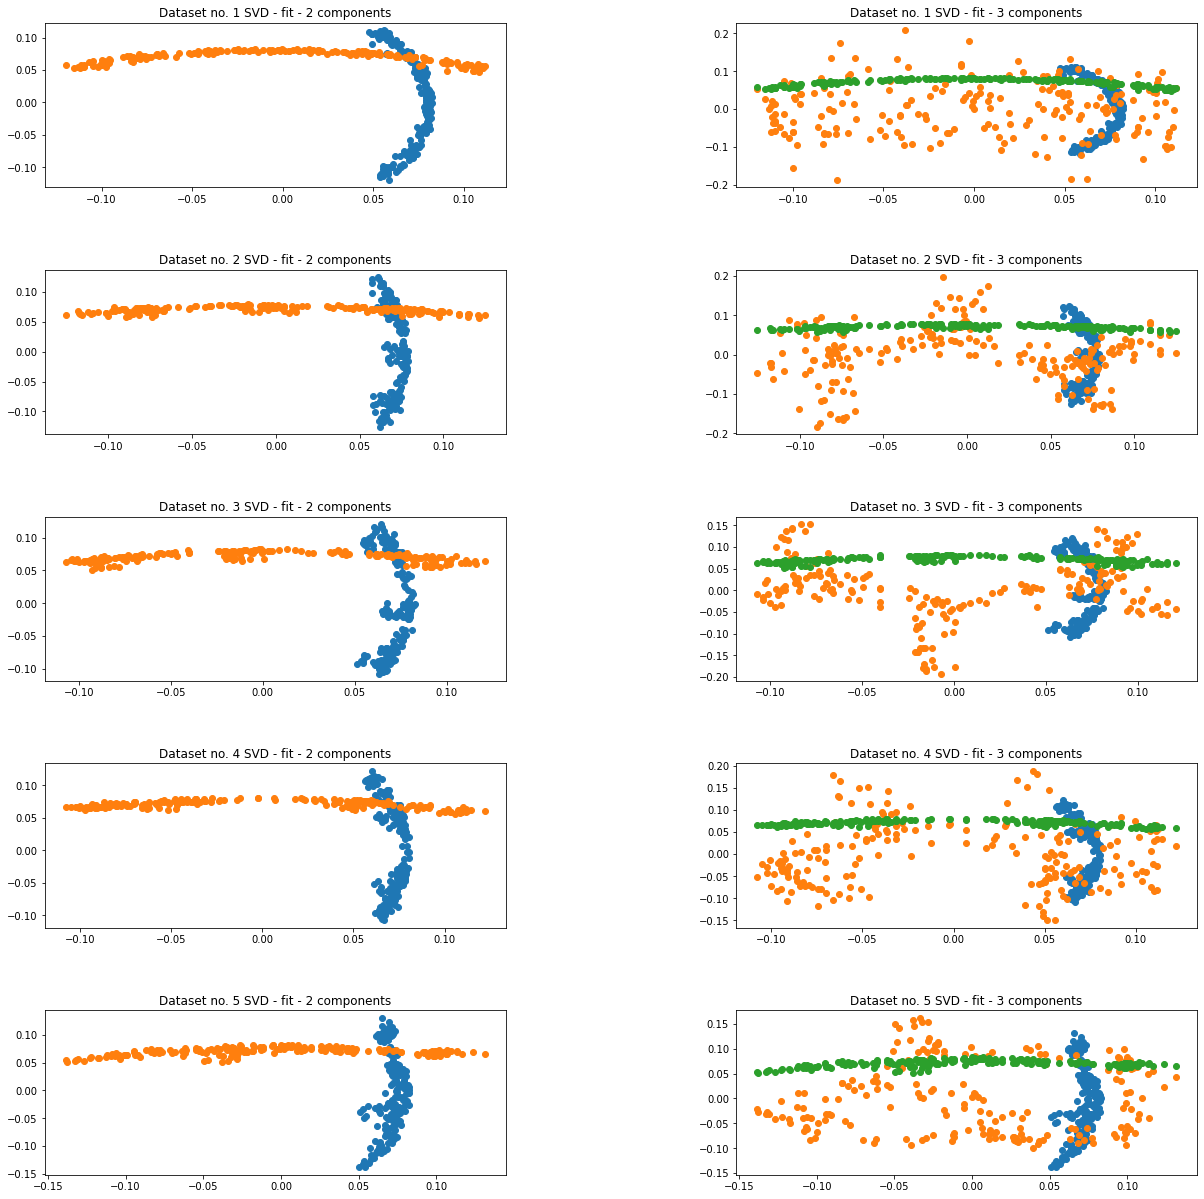

In [51]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

for i in range(1,6):
  # calculate SVD with fit method for each dataset for 2 and 3 components
  svd2 = TruncatedSVD(n_components=2, random_state=42).fit(datasets[i])
  svd3 = TruncatedSVD(n_components=3, random_state=42).fit(datasets[i])

  axes[i-1, 0].scatter(svd2.components_[0], svd2.components_[1])
  axes[i-1, 0].scatter(svd2.components_[1],svd2.components_[0])
  axes[i-1, 0].set_title("Dataset no. " + str(i) + " SVD - fit - 2 components")
  
  axes[i-1, 1].scatter(svd3.components_[0], svd3.components_[1])
  axes[i-1, 1].scatter(svd3.components_[1], svd3.components_[2])
  axes[i-1, 1].scatter(svd3.components_[1],svd3.components_[0])
  axes[i-1, 1].set_title("Dataset no. " + str(i) + " SVD - fit - 3 components")

  print("Total variance for dataset " + str(i) + " with n_comp = 2 is " + str(round(svd2.explained_variance_ratio_.sum(), 2)) + " and with n_comp = 3 is " + str(round(svd3.explained_variance_ratio_.sum(), 2)))

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

### t-distributed stochastic neighbor embedding (tsne)


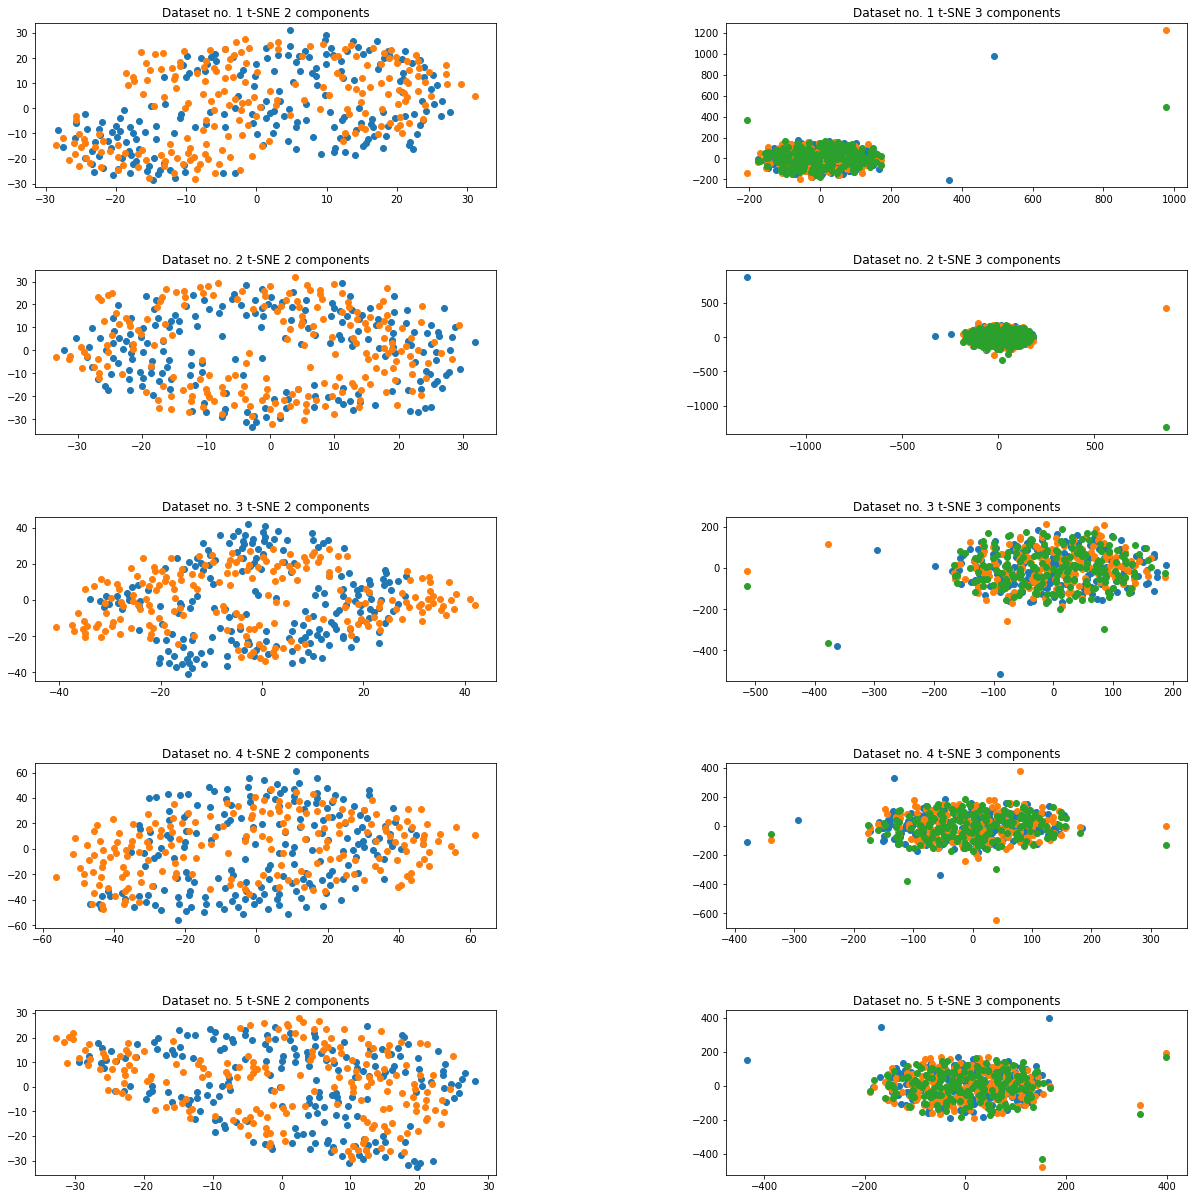

In [70]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

for i in range(1,6):
  # apply TSNE
  tsne2 = TSNE(n_components=2, perplexity=10).fit_transform(datasets[i])
  tsne3 = TSNE(n_components=3, perplexity=10).fit_transform(datasets[i])

  axes[i-1, 0].scatter(tsne2[:,0], tsne2[:,1])
  axes[i-1, 0].scatter(tsne2[:,1],tsne2[:,0])
  axes[i-1, 0].set_title("Dataset no. " + str(i) + " t-SNE 2 components")
  
  axes[i-1, 1].scatter(tsne3[:,0], tsne3[:,1])
  axes[i-1, 1].scatter(tsne3[:,1], tsne3[:,2])
  axes[i-1, 1].scatter(tsne3[:,1],tsne3[:,0])
  axes[i-1, 1].set_title("Dataset no. " + str(i) + " t-SNE 3 components")

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)
plt.show()


### UMAP

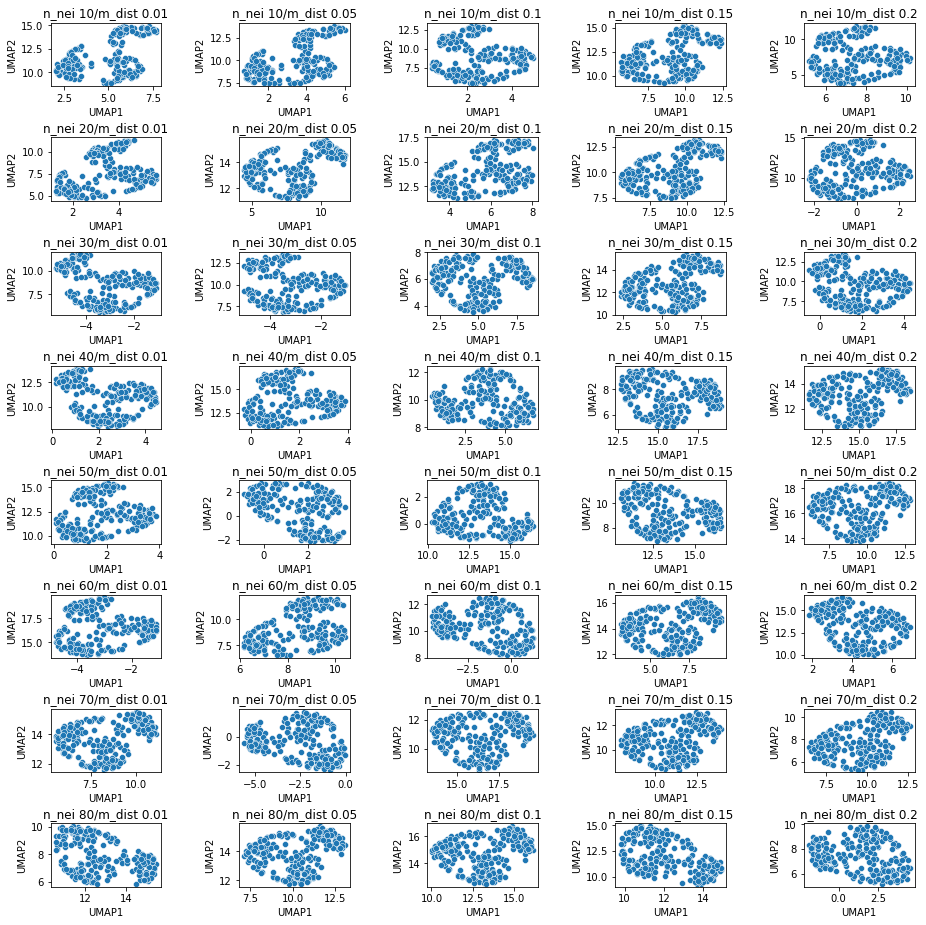

In [29]:
n_neighbors = [10, 20, 30, 40, 50, 60, 70, 80]
min_dist = [0.01, 0.05, 0.1, 0.15, 0.2]

fig, axes = plt.subplots(8, 5, figsize=(15, 15))

# check the several parameters of UMAP in the first dataset and visualize the results
for (index1, n_nei) in enumerate(n_neighbors):
  for (index2, m_dist) in enumerate(min_dist):
    umap_2d = UMAP(random_state=999, n_neighbors=n_nei, min_dist=m_dist)
    umap_emd = pd.DataFrame(umap_2d.fit_transform(datasets[1]), columns = ['UMAP1','UMAP2'])
    sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_emd, ax=axes[index1][index2]).set(title='n_nei ' + str(n_nei) + '/m_dist ' + str(m_dist))

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.7, 
                    hspace=0.8)
plt.show()

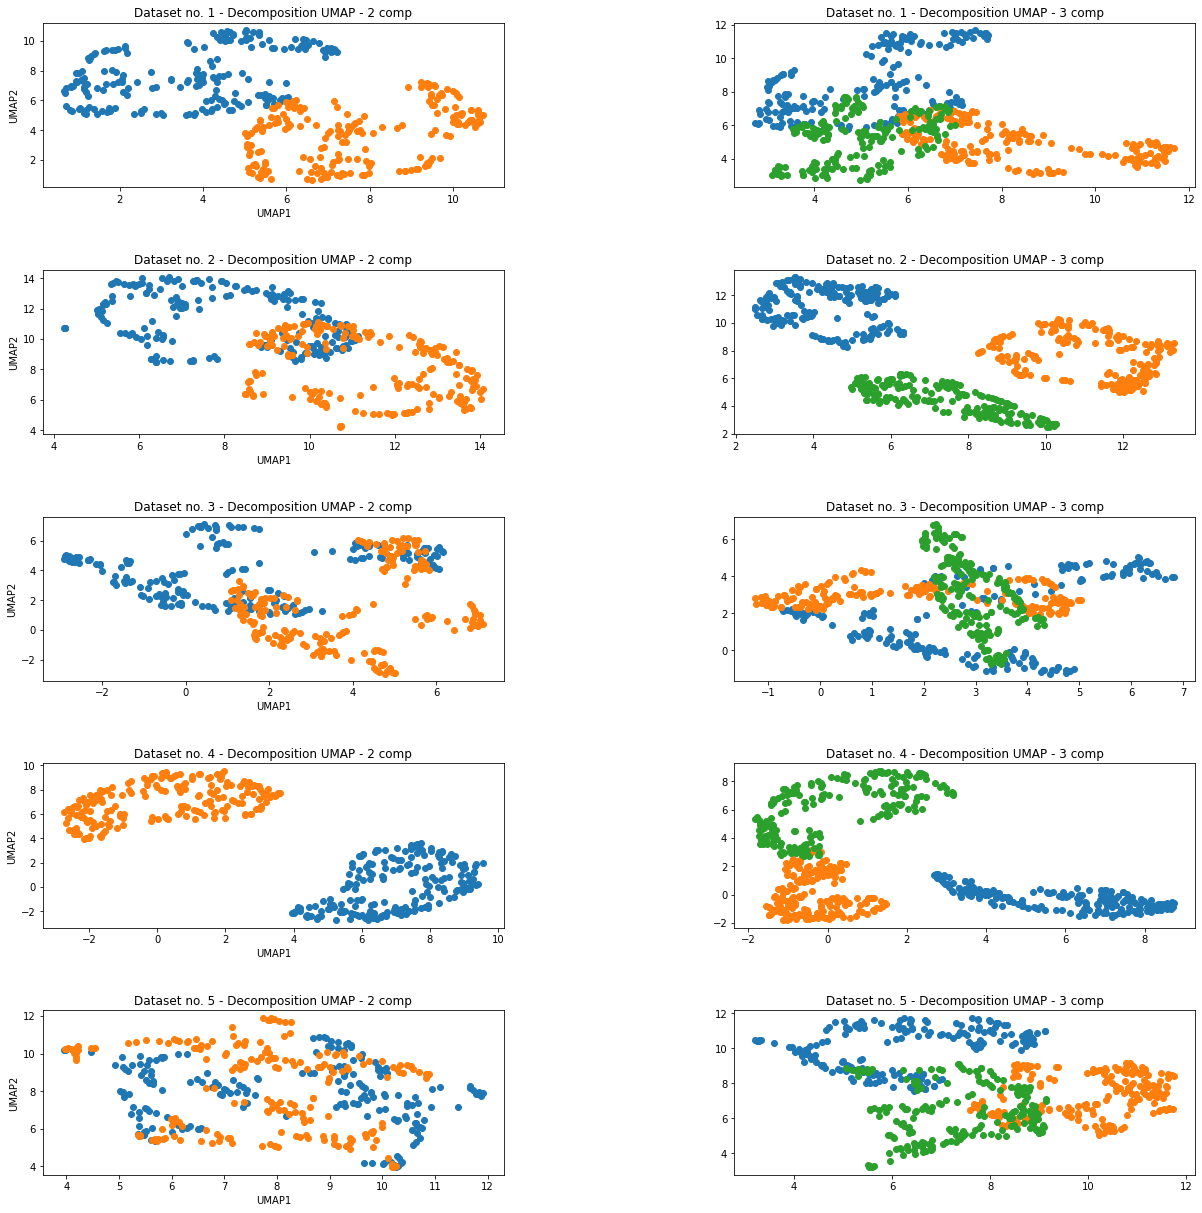

In [31]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

umap_emd_arr_2d = {}
umap_emd_arr_3d = {}
umap_emd_2d = {}
# umap_emd_3d = {}
for i in range(1,6):

  # select the UMAP that represent better the points with 2 components
  umap_2d = UMAP(random_state=999, n_neighbors=5, min_dist=0.05)
  umap_3d = UMAP(random_state=999, n_neighbors=5, min_dist=0.05, n_components=3)
  umap_emd_arr_3d[i] = umap_3d.fit_transform(datasets[i])
  umap_emd_arr_2d[i] = umap_2d.fit_transform(datasets[i])
  umap_emd_2d[i] = pd.DataFrame(umap_emd_arr_2d[i], columns = ['UMAP1','UMAP2'])
  # umap_emd_3d[i] = pd.DataFrame(umap_emd_arr_3d[i], columns = ['UMAP1','UMAP2','UMAP3'])

  # axes[i-1, 0].scatter(umap_emd[i].UMAP1, umap_emd[i].UMAP2)
  axes[i-1, 0].scatter(umap_emd_arr_2d[i][:,0],umap_emd_arr_2d[i][:,1])
  axes[i-1, 0].scatter(umap_emd_arr_2d[i][:,1],umap_emd_arr_2d[i][:,0])
  axes[i-1, 0].set_xlabel("UMAP1")
  axes[i-1, 0].set_ylabel("UMAP2")
  axes[i-1, 0].set_title("Dataset no. " + str(i) + " - Decomposition UMAP - 2 comp")

  # axes[i-1, 1].scatter(umap_emd[i].UMAP1, umap_emd[i].UMAP2)
  axes[i-1, 1].scatter(umap_emd_arr_3d[i][:,0],umap_emd_arr_3d[i][:,1])
  axes[i-1, 1].scatter(umap_emd_arr_3d[i][:,1],umap_emd_arr_3d[i][:,2])
  axes[i-1, 1].scatter(umap_emd_arr_3d[i][:,2],umap_emd_arr_3d[i][:,0])
  # axes[i-1, 1].set_xlabel("UMAP1")
  # axes[i-1, 1].set_ylabel("UMAP2")
  axes[i-1, 1].set_title("Dataset no. " + str(i) + " - Decomposition UMAP - 3 comp")

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

## Clustering

### Gaussian Mixture Model

In [110]:
bic = {}
aic = {}
clf = {}
n_components_range = range(1, 10)
cv_types = ["spherical", "tied", "diag", "full"]

for i in range(1,6):
    lowest_bic = np.infty
    bic_arr = []
    aic_arr = []
    # calculate the GaussianMixture models and their BIC and AIC
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(
                n_components=n_components, covariance_type=cv_type
            )
            gmm.fit(umap_emd_arr_3d[i])
            bic_arr.append(gmm.bic(umap_emd_arr_3d[i]))
            aic_arr.append(gmm.aic(umap_emd_arr_3d[i]))

            # save the model with the lowest BIC
            if bic_arr[-1] < lowest_bic:
                lowest_bic = bic_arr[-1]
                best_gmm = gmm
    
    bic[i] = np.array(bic_arr)
    aic[i] = np.array(aic_arr)
    clf[i] = best_gmm

color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])

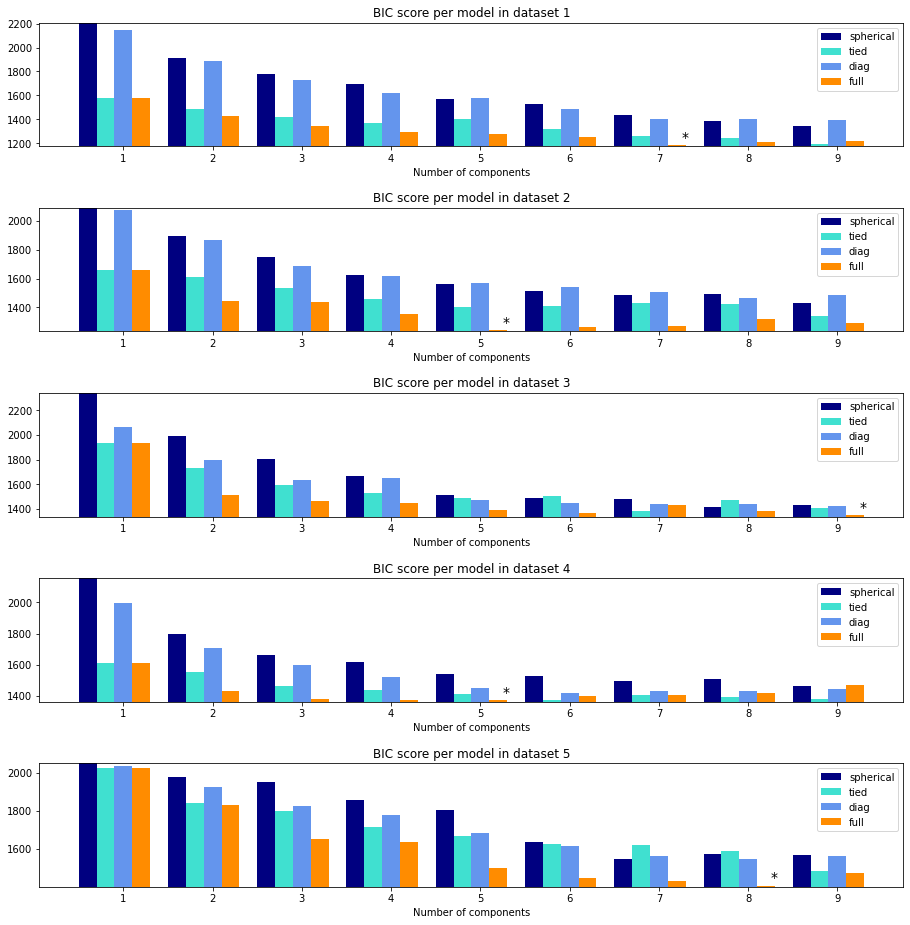

In [116]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

for j in range(1,6):
    bars = []
    # Plot the BIC scores in accordance with the covariance types and the number of components
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + 0.2 * (i - 2)
        bars.append(
            axes[j-1].bar(
                xpos,
                bic[j][i * len(n_components_range) : (i + 1) * len(n_components_range)],
                width=0.2,
                color=color,
            )
        )
    axes[j-1].set_xticks(n_components_range)
    axes[j-1].set_ylim([bic[j].min() * 1.01 - 0.01 * bic[j].max(), bic[j].max()])
    axes[j-1].set_title("BIC score per model in dataset " + str(j))
    xpos = (
        np.mod(bic[j].argmin(), len(n_components_range))
        + 0.65
        + 0.2 * np.floor(bic[j].argmin() / len(n_components_range))
    )
    axes[j-1].text(xpos, bic[j].min() * 0.97 + 0.03 * bic[j].max(), "*", fontsize=14)
    axes[j-1].set_xlabel("Number of components")
    axes[j-1].legend([b[0] for b in bars], cv_types)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)
plt.show()


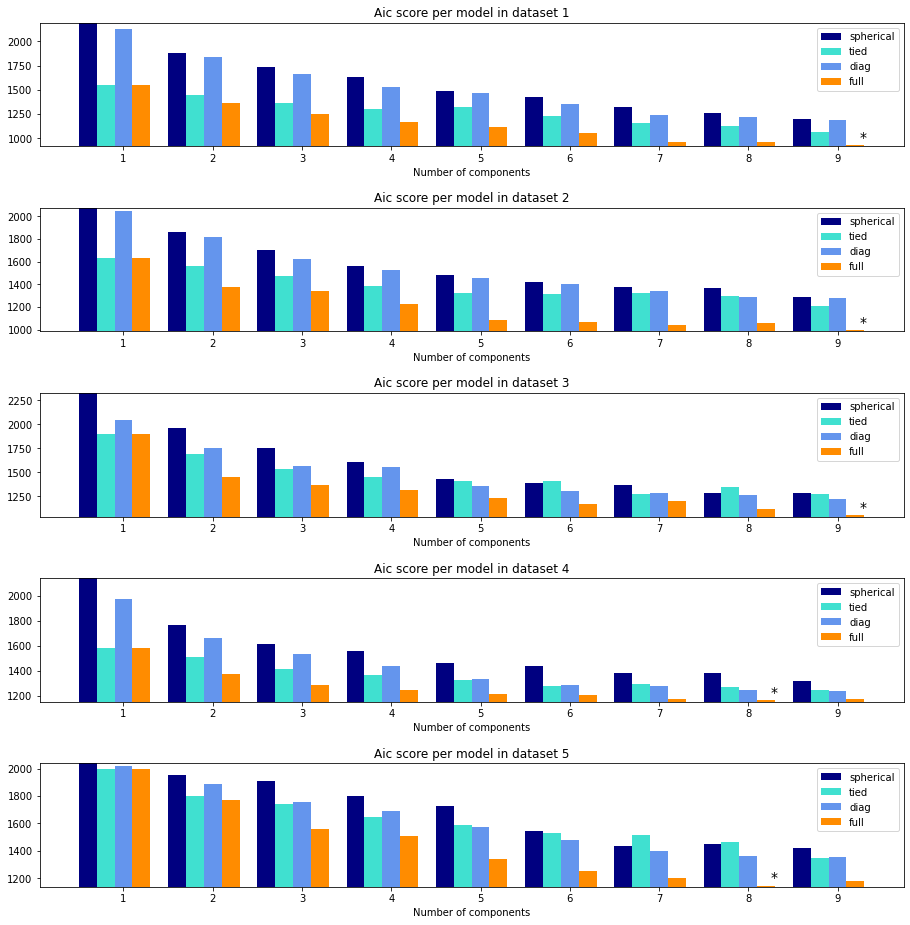

In [117]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

for j in range(1,6):
    bars = []
    # Plot the AIC scores in accordance with the covariance types and the number of components
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + 0.2 * (i - 2)
        bars.append(
            axes[j-1].bar(
                xpos,
                aic[j][i * len(n_components_range) : (i + 1) * len(n_components_range)],
                width=0.2,
                color=color,
            )
        )
    axes[j-1].set_xticks(n_components_range)
    axes[j-1].set_ylim([aic[j].min() * 1.01 - 0.01 * aic[j].max(), aic[j].max()])
    axes[j-1].set_title("Aic score per model in dataset " + str(j))
    xpos = (
        np.mod(aic[j].argmin(), len(n_components_range))
        + 0.65
        + 0.2 * np.floor(aic[j].argmin() / len(n_components_range))
    )
    axes[j-1].text(xpos, aic[j].min() * 0.97 + 0.03 * aic[j].max(), "*", fontsize=14)
    axes[j-1].set_xlabel("Number of components")
    axes[j-1].legend([b[0] for b in bars], cv_types)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

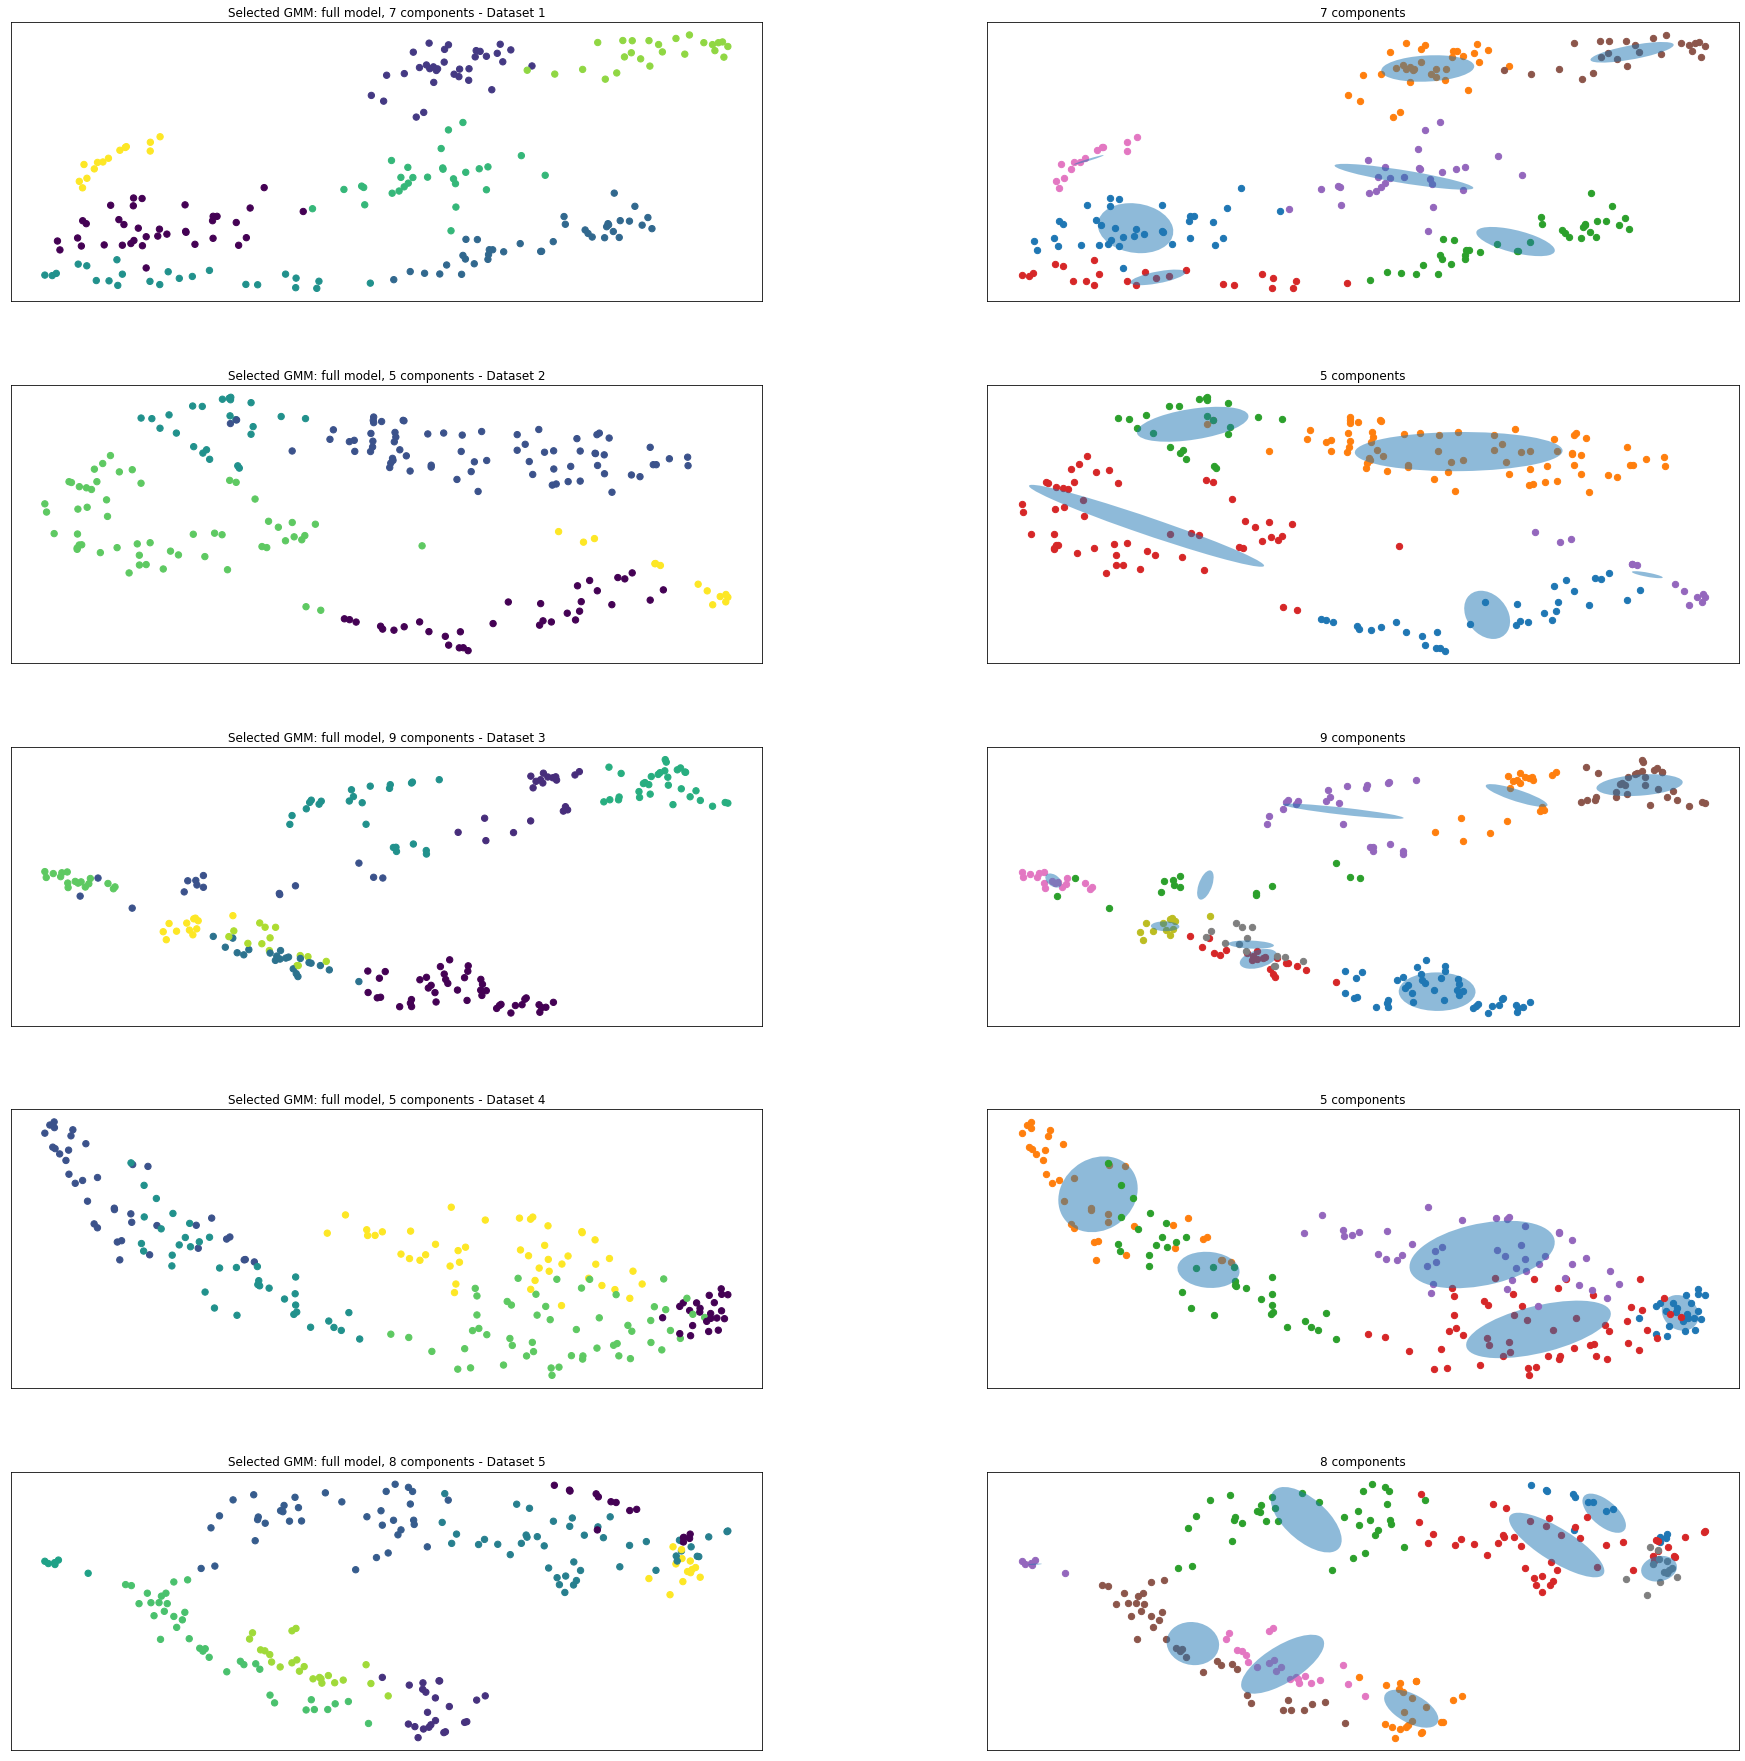

In [151]:
fig, axes = plt.subplots(5, 2, figsize=(30, 30))

for j in range(1,6):
    # Plot the best Gaussian Mixture model based on the lowest BIC
    # splot = plt.subplot(2, 1, 1)
    labels = clf[j].predict(umap_emd_arr_3d[j])
    axes[j-1, 0].scatter(umap_emd_arr_3d[j][:, 0], umap_emd_arr_3d[j][:, 1], c=labels, s=40, cmap='viridis')
    axes[j-1, 0].set_xticks(())
    axes[j-1, 0].set_yticks(())
    axes[j-1, 0].set_title(
        f"Selected GMM: {clf[j].covariance_type} model, "
        f"{clf[j].n_components} components - "
        f"Dataset {j}"
    )

    # plot with elipsoids
    for i, (mean, covar, color) in enumerate(zip(clf[j].means_, clf[j].covariances_, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(labels == i):
            continue
        axes[j-1, 1].scatter(umap_emd_arr_3d[j][labels == i, 0], umap_emd_arr_3d[j][labels == i, 1], s=40)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle)
        ell.set_clip_box(axes[j-1, 1].bbox)
        ell.set_alpha(0.5)
        axes[j-1, 1].add_artist(ell)

    axes[j-1, 1].set_xticks(())
    axes[j-1, 1].set_yticks(())
    axes[j-1, 1].set_title(f"{clf[j].n_components} components")

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.show()

### Bayesian Gaussian Mixture Model

Estimated number of clusters: 5 in Dataset 1
Estimated number of clusters: 4 in Dataset 2
Estimated number of clusters: 5 in Dataset 3
Estimated number of clusters: 5 in Dataset 4
Estimated number of clusters: 4 in Dataset 5


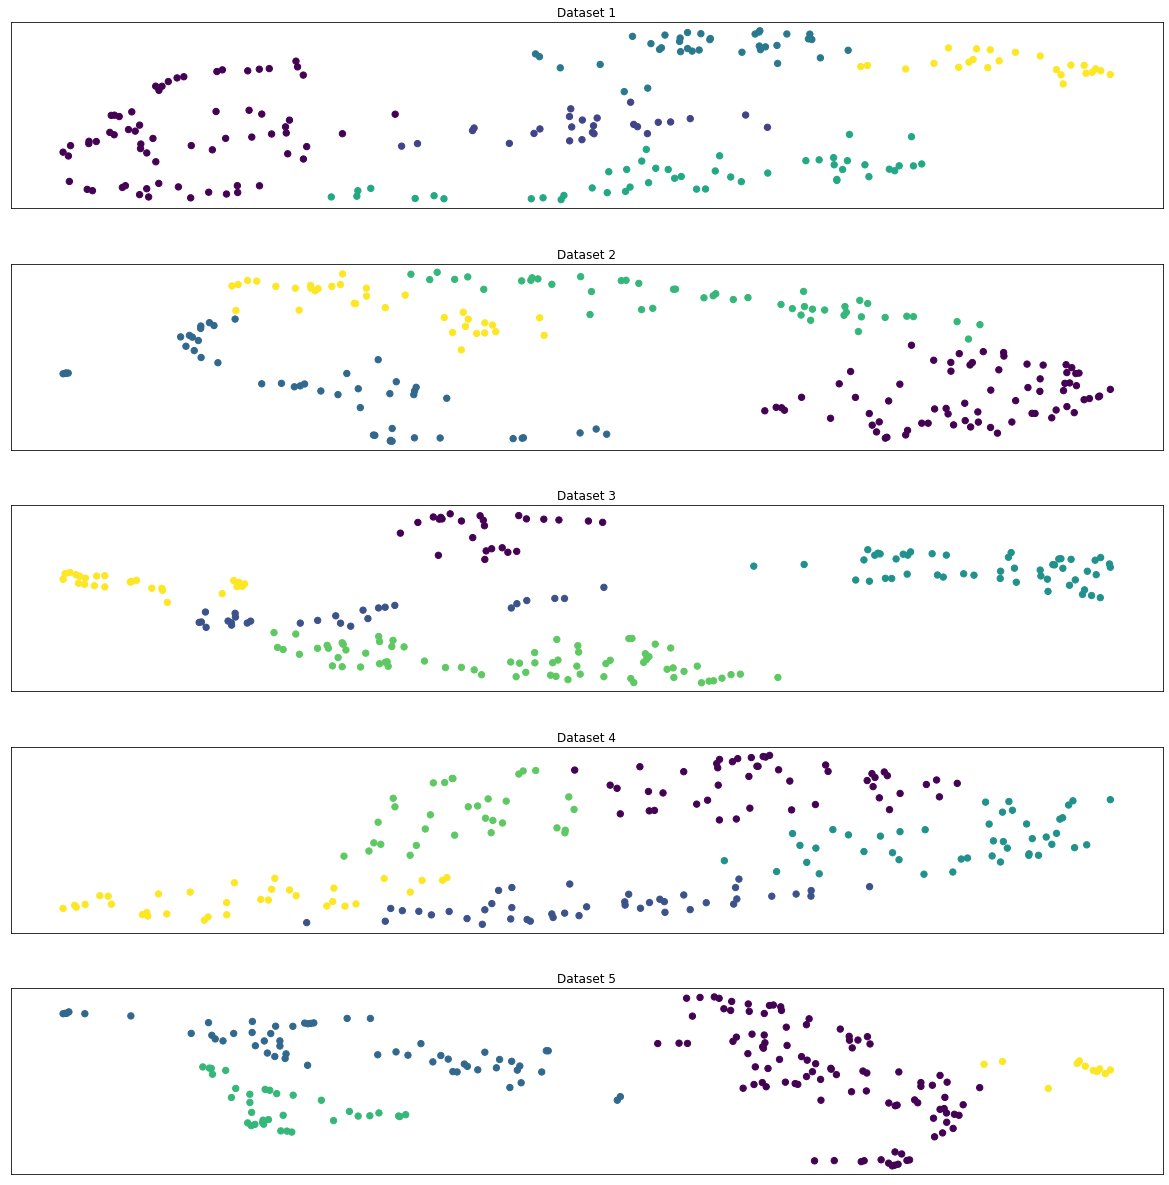

In [45]:
fig, axes = plt.subplots(5, 1, figsize=(20, 20))

for j in range(1,6):
    # Fit a Gaussian mixture with EM
    bay_gmm = mixture.BayesianGaussianMixture(
        n_components=10, n_init=10
    )
    bay_gmm.fit(umap_emd_arr_2d[j])

    bay_gmm_weights = bay_gmm.weights_
    
    n_clusters_ = (np.round(bay_gmm_weights, 2) > 0).sum()
    print('Estimated number of clusters: ' + str(n_clusters_) + ' in Dataset ' + str(j))

    labels = bay_gmm.predict(umap_emd_arr_2d[j])
    axes[j-1].scatter(umap_emd_arr_2d[j][:, 0], umap_emd_arr_2d[j][:, 1], c=labels, s=40)
    axes[j-1].set_xticks(())
    axes[j-1].set_yticks(())
    axes[j-1].set_title("Dataset " + str(j))

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.show()


### K-means

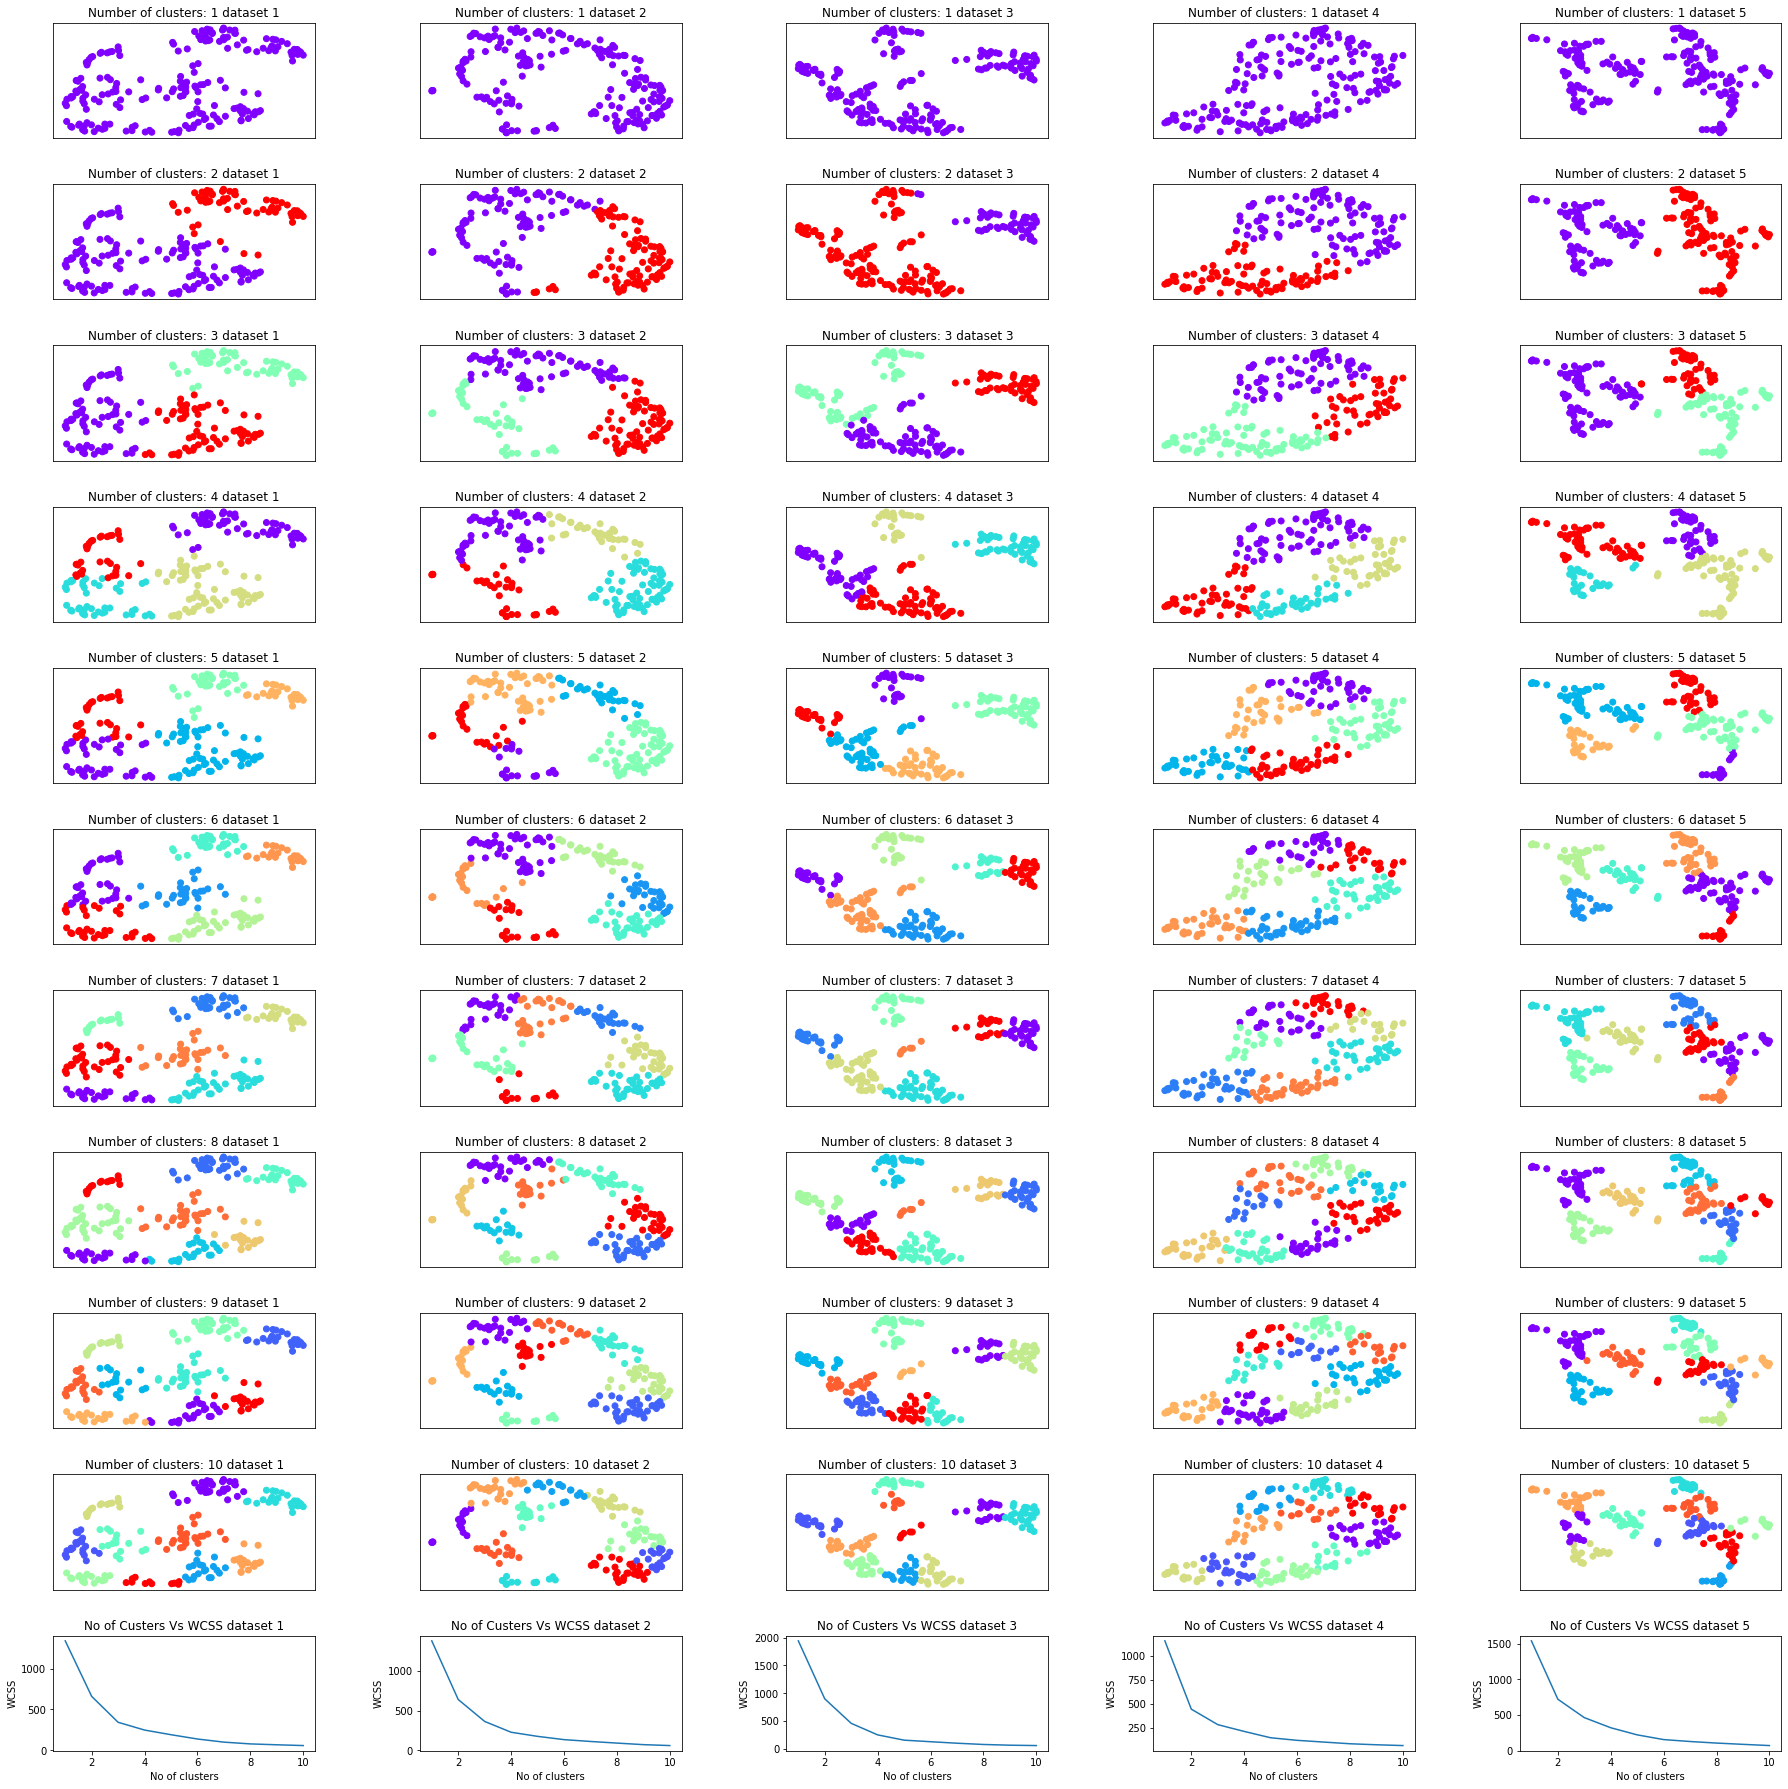

In [156]:
number_clusters = range(1,11)

fig, axes = plt.subplots(11, 5, figsize=(30, 30))

for j in range(1,6):
  wcss = []
  for i in number_clusters:
    # clustering
    kmeans = KMeans(i) # initialize the KMeans by setting the number of centroids
    kmeans.fit(umap_emd_2d[j])

    # clustering resutls
    identified_clusters = kmeans.fit_predict(umap_emd_2d[j])

    wcss.append(kmeans.inertia_)

    # plot clusters
    data_with_clusters = umap_emd_2d[j].copy()
    data_with_clusters['Clusters'] = identified_clusters 
    axes[i-1, j-1].scatter(data_with_clusters['UMAP1'],data_with_clusters['UMAP2'],c=data_with_clusters['Clusters'],cmap='rainbow')
    axes[i-1, j-1].set_title("Number of clusters: " + str(i) + " dataset " + str(j))
    axes[i-1, j-1].get_xaxis().set_visible(False)
    axes[i-1, j-1].get_yaxis().set_visible(False)
  
  axes[i, j-1].plot(number_clusters,wcss)
  axes[i, j-1].set_title('No of Custers Vs WCSS dataset ' + str(j))
  axes[i, j-1].set_xlabel('No of clusters')
  axes[i, j-1].set_ylabel('WCSS')
  axes[i, j-1].get_xaxis().set_visible(True)
  axes[i, j-1].get_yaxis().set_visible(True)


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()
